### Regime Identification in Multivariate Time-series

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [84]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [85]:
def read_file(file_path):
    # Check the file extension
    file_extension = file_path.split('.')[-1].lower()

    # Read the file based on the extension
    if file_extension in ['xls', 'xlsx']:
        data = pd.read_excel(file_path)
    elif file_extension == 'csv':
        data = pd.read_csv(file_path)
    elif file_extension == 'h5':
        data = pd.read_hdf(file_path)
    else:
        raise ValueError(f"Unsupported file extension: {file_extension}")

    return data

In [97]:
# Load data
file_path = r'../datasets/hurricane/hpw.xls'  # Replace with the actual file path
data = read_file(file_path)
data.head()

,Date,Hs (m),SLP (mbar),W (km/h)
0,2012-06-01 00:00:00,0.8437,1018.4,16.92
1,2012-06-01 01:00:00,0.8644,1019.0,16.20
2,2012-06-01 02:00:00,0.8607,1018.9,16.92
3,2012-06-01 03:00:00,0.8376,1018.6,15.48
4,2012-06-01 04:00:00,0.8353,1018.1,16.92


In [98]:
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, format = '%Y-%m-%d').strftime('%m/%d/%Y')

data.head()

ValueError: time data "2012-06-01 00:00:00" doesn't match format "%m/%d/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [95]:
data

TypeError: 'Index' object is not callable

In [91]:
# start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4393 entries, 2012-06-01 00:00:00 to 2012-12-01 00:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs (m)      4387 non-null   float64
 1   SLP (mbar)  4391 non-null   float64
 2   W (km/h)    4391 non-null   float64
dtypes: float64(3)
memory usage: 137.3+ KB


In [ ]:
data.isnull().sum()

Hs (m)        6
SLP (mbar)    2
W (km/h)      2
dtype: int64

In [ ]:
data = data.dropna(how='any',axis=0) 
# data = data.drop(columns=['Date'])
columns = data.columns
data.isnull().sum()

Hs (m)        0
SLP (mbar)    0
W (km/h)      0
dtype: int64

In [ ]:
data.head()

,Hs (m),SLP (mbar),W (km/h)
Date,,,
2012-06-01 00:00:00,0.8437,1018.4,16.92
2012-06-01 01:00:00,0.8644,1019.0,16.20
2012-06-01 02:00:00,0.8607,1018.9,16.92
2012-06-01 03:00:00,0.8376,1018.6,15.48
2012-06-01 04:00:00,0.8353,1018.1,16.92


In [ ]:
data = data.apply(normalize)

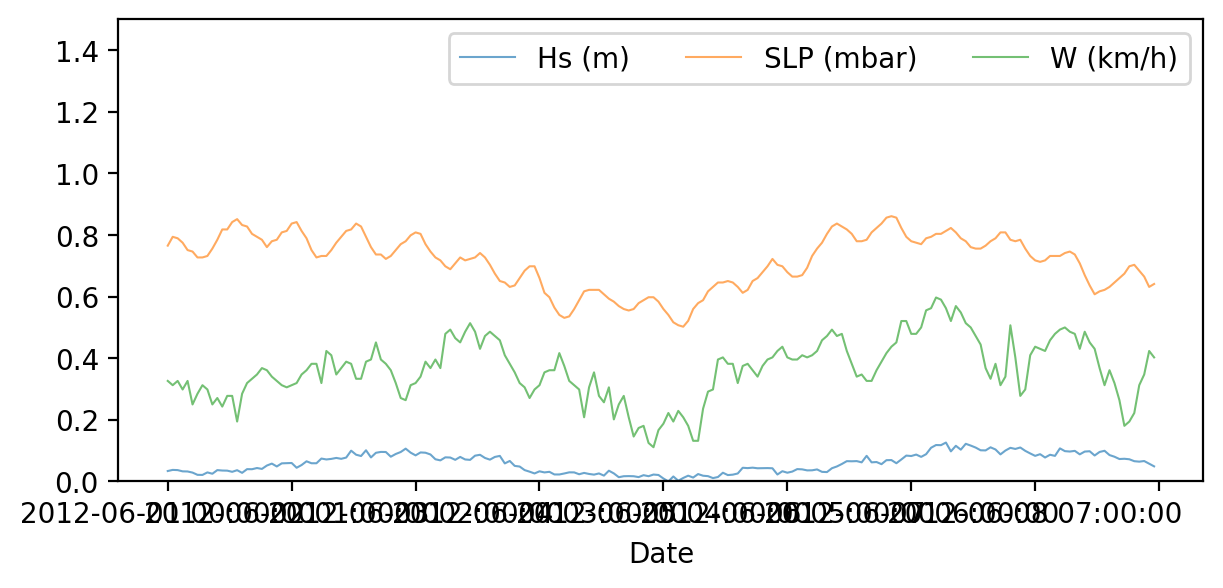

In [ ]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']
toplot = columns

for i in toplot:
    data[i][:200].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)


plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [ ]:
# Desired number of clusters
k = 2

# Sliding window size
winsize = 150 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = 'full' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, k, metricR, dim)

Regimes:(1, 0) (1, 150) (1, 300) (1, 450) (1, 600) (1, 750) (1, 900) (1, 1050) (1, 1200) (1, 1350) (1, 1500) (1, 1650) (1, 1800) (0, 1950) (1, 2100) (1, 2250) (1, 2400) (1, 2550) (1, 2700) (1, 2850) (1, 3000) (0, 3150) (0, 3300) (0, 3450) (0, 3600) (1, 3750) (1, 3900) (1, 4050) (0, 4200)


In [ ]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

4350 (4387, 3)


In [ ]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

<Figure size 2400x800 with 0 Axes>

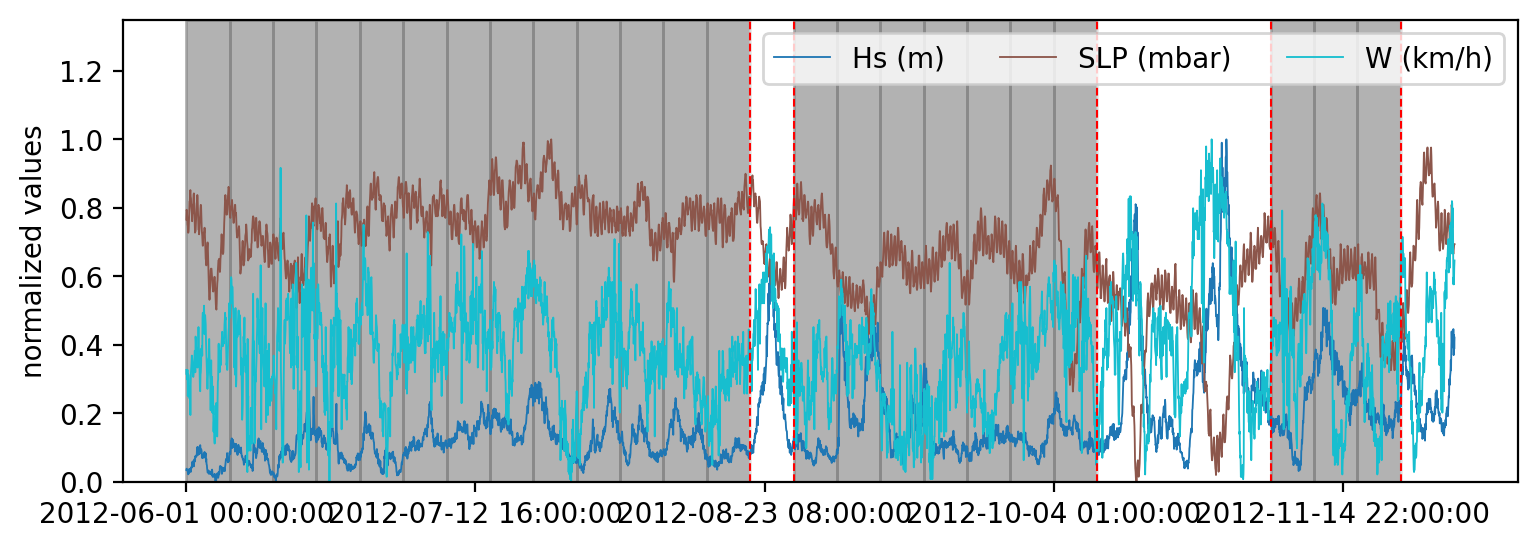

In [ ]:
var_to_plot = columns
regimes.plot_regimes(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')